###  Домашнее задание к вебинару 7

- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

_________________
**Для задания взят датасет с  признаками, характеризующими пациентов (физиологические и медицинские)**   
**Задача** -  предсказать наличие сердечно-сосудистых заболеваний на основе признаков, имеющихся у пациентов

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 
Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

In [131]:
# Загрузим датасет

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier


import shap

In [132]:
data = pd.read_csv('cardio.csv', ';')
data.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [133]:
data.shape

(70000, 13)

In [134]:
data.columns.tolist()

['id',
 'age',
 'gender',
 'height',
 'weight',
 'ap_hi',
 'ap_lo',
 'cholesterol',
 'gluc',
 'smoke',
 'alco',
 'active',
 'cardio']

In [135]:
# Проверим наличие пропусков

data.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [136]:
# Изучим типы данных
data.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [137]:
data.nunique()

id             70000
age             8076
gender             2
height           109
weight           287
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64

In [138]:
# Удалим признак id
# Остальные признаки имеют более 1 значения, а значит на этом этапе можно сделать вывод, 
# что они все могут быть полезны

data.drop('id', axis =1, inplace=True)

In [139]:
#Для удобства переименуем целевой признак
data.rename(columns = {'cardio': 'target'}, inplace=True)

In [140]:
# Посмотрим распределение целевой переменной
data.target.value_counts()

0    35021
1    34979
Name: target, dtype: int64

Дисбаланс классов практически отсутсует

**Разделим наши данные на тренировочную и тестовую выборки**

In [141]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', 1), 
                                                    data['target'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [142]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

In [143]:
# 1) отскалируем количественные признаки
scaler = StandardScaler()
X_train[continuos_cols] = scaler.fit_transform(X_train[continuos_cols])
X_test[continuos_cols] = scaler.transform(X_test[continuos_cols])

In [144]:
# 2) Переведем в дамми категориальные признаки

dummies_train = []
for col in cat_cols:
    dummies_train.extend(pd.get_dummies(X_train[col], prefix=col).columns.tolist())
    X_train = pd.concat([X_train, pd.get_dummies(X_train[col], prefix = col)], axis = 1)

dummies_test = []    
for col in cat_cols:
    dummies_test.extend(pd.get_dummies(X_train[col], prefix=col).columns.tolist())
    X_test = pd.concat([X_test, pd.get_dummies(X_test[col], prefix = col)], axis = 1)
    
len(dummies_train) == len(dummies_test)

True

In [145]:
#train_columns = continuos_cols.extend(base_cols, dummies_train)
X_train = X_train[continuos_cols + base_cols + dummies_train]
X_test = X_test[continuos_cols + base_cols + dummies_train]

**Обучим модель**

In [146]:
classifier = GradientBoostingClassifier(random_state = 42)

classifier.fit(X_train, y_train)
y_predict = classifier.predict_proba(X_test)[:,1]


Рассчитаем метрики

In [147]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [148]:
precision, recall, thresholds = precision_recall_curve(y_test, y_predict)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.394947, F-Score=0.740, Precision=0.698, Recall=0.788


### SHAP

Построить важности признаков для:  
    - всего тестового набора данных (summary_plot - дать интерпретацию)  
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [149]:
explainer = shap.TreeExplainer(classifier)

In [150]:
shap_values = explainer.shap_values(X_test)

#if isinstance(shap_values, list):
#    shap_values_ = shap_values[1]

In [151]:
len(shap_values)

17500

**Выведем визуализацию для всех объектов**

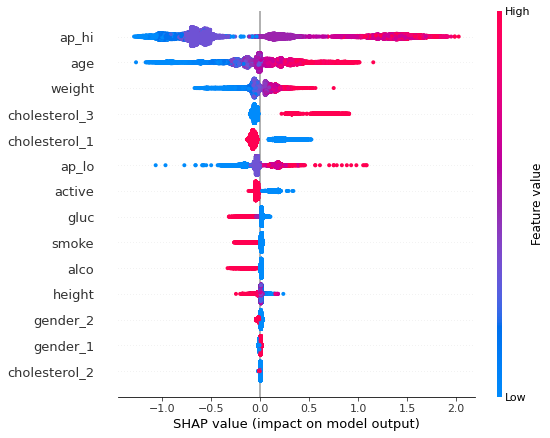

In [152]:
shap.summary_plot(shap_values, X_test)

**Вывод**  
* Наиболее влияющий показатель - артериальное давление. Чем выше артериальное давление, тем вероятнее наличие сердечно сосудистого заболевания и наоборот. Причем ниже на графике можно найти признак ap_lo. Его влияние ниже.
* Аналогичная ситуация по признаку возраст. У людей более старшего возраста вероятнее может быть положительный класс - СС заболевание
* Такая же динамика у признаков веса и у признака холестерина (cholesteron 3 -наивысший показатель холестерина) - высокие значения обозначают высокую вероятность наличие СС заболевания  
    
* Обратая ситуция наблюдается у признаков активности, показателя глюкозвы в крови, и **как ни странно - курение, употребление алкоголя** и рост. При наличии этих показателей и их высоких значениях, вероятность СС заболеваний ниже. Предполагаю, что это может потребовать дополнительных исследований.
  
* Пол не оказывает практически никакого влияния

In [153]:
# Построим аналог для топ 10 признаков
n=10

#найдем топ 10% объектов

In [154]:
pred_sorted_indices = y_predict.argsort()
part_for_plot = int(len(pred_sorted_indices)*n/100)
part_for_plot

1750

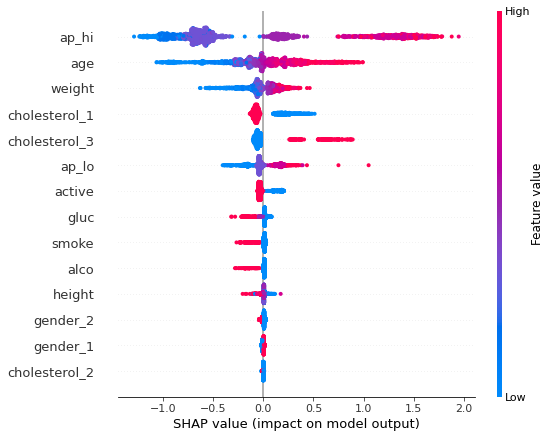

In [155]:
shap.summary_plot(shap_values[:part_for_plot, :], X_test.iloc[:part_for_plot, :])

**Вывод:** тенденция на выборке в 10% наиболее хорошо классифицированных объектов аналогична общему графику

**Для отдельных наблюдений выведем force_plot и интерпретируем результат**

In [156]:
# построим force_plot на рандомном объекте

shap.initjs()

ix = np.random.randint(0, X_test.shape[0])
print(ix)
shap.force_plot(explainer.expected_value, shap_values[ix, :], X_test.iloc[ix,:])


5146


In [157]:
ix = np.random.randint(0, X_test.shape[0])
print(ix)
shap.force_plot(explainer.expected_value, shap_values[ix, :], X_test.iloc[ix,:])

9412


In [158]:
ix = np.random.randint(0, X_test.shape[0])
print(ix)
shap.force_plot(explainer.expected_value, shap_values[ix, :], X_test.iloc[ix,:])

13163


**Вывод:** выше выведены графики для 3 случайно выбранных объектов. Общая тенденция примерно похожа.

* Как уже было отмечено в выоде к общему графику, очевидно наибольшее влияние признака ap_hi (высокого артериального давления). Его низкие значения снижают вероятность наличия сердечно-сосудистых заболеваний.   
* Аналогично действуют признак вес и холестерин  
* Повышение величины активности увеличивает вероятность наличия СС заболевания

In [159]:
# Теперь попробуем сделать такой график для группы объектов

ix = np.random.randint(0, X_test.shape[0], size = 50)
print(ix)
shap.force_plot(explainer.expected_value, shap_values[ix, :], X_test.iloc[ix,:])

[14202  9615  3164  8979  1144  4255 12287  8974  1266  9368  9958 11235
 12708 10660   137  2498 16195  3744  7945  6916  9486 13426  3146  2870
 13166 14764  3004 16153  4935  1696  6950  9907   936  4849 10786 13321
  4169  9679  8566   830  1081  6448 16050 16365  8032  9761  7011  9598
 11016 14166]


**Вывод:** на графике можно заметить, как изменяются значения, показываемые признаками.  
С изменением диапазона признаков, меняется и вероятность 1 класса (наличия СС заболевания) - например, главный признак ap_hi слева на графике самый большой и по значению и по количеству значений (красная и широкая полоса) и порог вероятности там выше, а правее уже меньше (синий цвет) и вероятность, соответственно, ниже.  
  
 
Видно, что два самых влиятельных признака приводят в сторону наличия СС заболевания (1 класс) при больших значения и в сторону их отсутствия при низких значениях.

In [160]:
# И для группы еще побольше

ix = np.random.randint(0, X_test.shape[0], size = 500)
print(ix)
shap.force_plot(explainer.expected_value, shap_values[ix, :], X_test.iloc[ix,:])

[  332  2632  9771 16221  5016  3516 16421 13468  1898 11646 14392 17111
 11553  5203  8590 12646  2240    48  8198 14943  8801  6007 10337 14116
  5943 10135  3648 11294  1010 16582 11509 13302  5026 11249 16098  8370
 11141  9288 14017  2710 10336   740 11108  1645  9376  3099  5559  3439
   203  8839 10588  6598  9082 16283 15087 11849  3385 10268 11165  4893
 17166 15931  8427  5884   891 12075 10360 14661 13479 13354 13338  3582
   803  5946  5573  5720  2902 11095 10985 11156  8504 10854 10268  7885
 16510  5834 10603 11664 14206 17432  9690 14017  5609  4500  9651 16429
 16132 13274 15976 13710  5464 12084  4667  8920  5550 11072  8747  8394
   445  1247  8980  8071 11930 10330 11010  3784 11631  9818  6590 15377
  2202  6529 14167  4449  6173  4862  4355  3342   840  6802 10160 13855
  4646 13313  8745  2951 14728  8837  4634   416 11617 10208  3208  2544
 12570 14978  3146 15105  1636 14541 17223 11539 12478 13670  3564 17237
 13522  4793  3030  9475 14249  9997  3351 13766   